In [1]:
!pip install pennylane
!python -m pip install pennylane-sf
# !pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 8.7 MB/s eta 0:00:00

In [2]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# import nlopt
import strawberryfields as sf
from strawberryfields import ops

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


env: OMP_NUM_THREADS=1


In [3]:
np.random.seed(0)

# Dataset

In [4]:
def create_data_set(drop: float):
    np.random.seed(17)
    l = 150
    n = 2

    X1 = np.array([[-1, -1]]) + drop*np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop*np.random.randn(l, n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    X = np.vstack((X1[10:], X2[10:]))
    ValX = np.vstack((X1[:10], X2[:10]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(l-10), [1]*(l-10)])
    ValY = np.hstack([[0]*10, [1]*10])

    return np.array(X, requires_grad=False), np.array(y, requires_grad=False), np.array(ValX, requires_grad=False), np.array(ValY, requires_grad=False)

In [5]:
def visualize_dataset(trainX, trainY, ValX, ValY)-> None:
    colors = ['blue', 'red', 'yellow', 'green']

    for k in np.unique(trainY):
        plt.plot(trainX[trainY==k, 0], trainX[trainY==k, 1], 'o', label='class {}'.format(k), color = colors[k])

    for k in np.unique(ValY):
        plt.plot(ValX[ValY==k, 0], ValX[ValY==k, 1], 'o', label='class {}'.format(k), color = colors[k+2])

    plt.legend(loc='best')
    plt.show()
    plt.close()

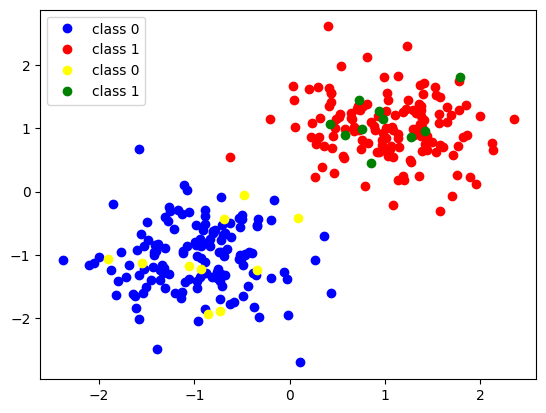

In [6]:
trainX, trainY, ValX, ValY = create_data_set(0.5)

visualize_dataset(trainX, trainY, ValX, ValY)

# Custom Model \

In [18]:
shots = 1000  # кол-во измерений для набора статистики
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=7, shots=shots)

In [19]:
params_num = 6
params = np.array([0.5]*params_num, requires_grad=True)


def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)
    
    qml.Beamsplitter(np.pi / 4, 0.0, wires=[0, 1])
    # qml.Rotation(params[2], wires=0)
    # qml.Rotation(params[3], wires=1)
    qml.Displacement(params[0], 0.0, wires=0)
    qml.Displacement(params[1], 0.0, wires=1)
    qml.QuadraticPhase(params[2], wires=0)
    qml.QuadraticPhase(params[3], wires=0)
    qml.Kerr(params[4], wires=0)
    qml.Kerr(params[5], wires=1)


@qml.qnode(dev)
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(np.array([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev)
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(np.array([0,2], requires_grad=False), wires=[0,1]))


def classifier(params, x):
    o0 = circuit_0(params,x)
    o1 = circuit_1(params,x)
    p0 = o0/(o0+o1)
    return p0  # , 1-p0

In [20]:
dcircuit = qml.jacobian(classifier)
dcircuit(params, trainX[0])

array([1517194.61356125,  129087.68676566,  -10942.33632389,
       1339017.90581497, 1362417.44077913, 2443864.35732775])

In [21]:
print(qml.draw(circuit_0)(params, trainX[10]))

0: ──S(1.50,-1.58)─╭BS(0.79,0.00)──D(0.50,0.00)──P(0.50)─────P(0.50)──Kerr(0.50)─┤ ╭<|20⟩⟨20|>
1: ──S(1.50,0.67)──╰BS(0.79,0.00)──D(0.50,0.00)──Kerr(0.50)──────────────────────┤ ╰<|20⟩⟨20|>


In [22]:
def square_loss(labels, predictions):
    loss = np.sum((labels - np.absolute(predictions)) ** 2) / len(labels)
    # print(loss)
    return loss

def log_loss(labels, predictions):
    loss = 0
    for i in range(len(labels)):
        loss = loss - (labels[i] * np.log(predictions[i]) + (1 - predictions[i]) * np.log(predictions(1 - predictions[i])))

    return loss

# def accuracy(labels, predictions):
#     acc = np.sum(np.where(np.abs(labels - predictions) < 1e-5, 1, 0))
#     return acc

# def square_loss(labels, predictions):
#     loss = 0
#     print(f'predictions: {predictions}')
#     for l, p in zip(labels, np.absolute(predictions)):
#         loss = loss + (l - p) ** 2
#     loss = loss / len(labels)
#     print(loss)
#     return loss

def accuracy(labels, predictions):
    acc = 0
    pred = np.round(predictions, requires_grad=False)
    for l, p in zip(labels, np.absolute(pred, requires_grad=False)):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

In [23]:
def cost(var, data_input, labels):
    predictions = np.array([classifier(var, x) for x in data_input], requires_grad=True)
    squared_loss = square_loss(labels, predictions)
    
    return np.absolute(squared_loss)

In [ ]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

optimizer = qml.optimize.AdamOptimizer(stepsize=0.025)
# optimizer = qml.GradientDescentOptimizer(stepsize=0.025)
steps = 40
var = np.array([0.5]*params_num, requires_grad=True)
for step in range(steps):
    var = optimizer.step(lambda v: cost(v, trainX, trainY), var)

    print(f'trainable params: {var}')

    predictions = np.array([classifier(var, x) for x in ValX], requires_grad=False)
    val_accuracy = accuracy(ValY, np.round(predictions))
    val_loss = square_loss(ValY, predictions)

    predictions = np.array([classifier(var, x) for x in trainX], requires_grad=False)
    train_accuracy = accuracy(trainY, np.round(predictions))
    train_loss = square_loss(trainY, predictions)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

trainable params: [0.525 0.525 0.525 0.525 0.525 0.525]
Iter:     1 | Train Loss: 0.4419392 | Train accuracy: 0.41785714285714287 | Val Loss: 0.3752783 | Val_accuracy: 0.45 
trainable params: [0.54967962 0.54285302 0.5483915  0.53517468 0.54393073 0.54917609]
Iter:     2 | Train Loss: 0.4282750 | Train accuracy: 0.4607142857142857 | Val Loss: 0.3920809 | Val_accuracy: 0.5 
trainable params: [0.56886709 0.55775574 0.56731536 0.54368591 0.55909062 0.5686721 ]
Iter:     3 | Train Loss: 0.7255378 | Train accuracy: 0.5071428571428571 | Val Loss: 0.3595723 | Val_accuracy: 0.6 
trainable params: [0.58858334 0.57345653 0.5856278  0.55673556 0.57241714 0.58950569]
Iter:     4 | Train Loss: 0.3791426 | Train accuracy: 0.5178571428571429 | Val Loss: 0.3309185 | Val_accuracy: 0.55 
trainable params: [0.60963931 0.59213004 0.60242472 0.57392288 0.58666791 0.60929515]
Iter:     5 | Train Loss: 0.3567927 | Train accuracy: 0.5357142857142857 | Val Loss: 0.3783205 | Val_accuracy: 0.5 
trainable params:

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(range(1, steps+1), train_loss_history, label='train loss')
axs[0].plot(range(1, steps+1), val_loss_history, label='val loss')
# axs[0].
axs[0].legend()

axs[1].plot(range(1, steps+1), train_acc_history, label='train_accuracy')
axs[1].plot(range(1, steps+1), val_acc_history, label='val accuracy')
axs[1].legend()

plt.show()

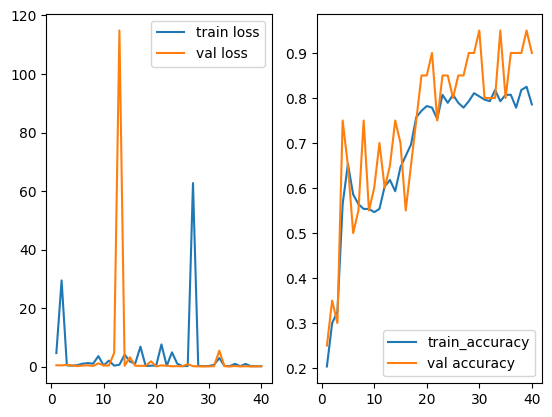

In [18]:
epochs = 40
model = Sequential([Dense(2, activation=tf.nn.softmax, input_shape=[2]), Dense(2, activation=tf.nn.softmax)])
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_history = model.fit(
    trainX,
    trainY,
    validation_data=(ValX, ValY),
    batch_size=2,
    epochs=epochs,
    verbose=2
)

Epoch 1/40
140/140 - 2s - loss: 0.6542 - accuracy: 0.6000 - val_loss: 0.6382 - val_accuracy: 0.8000 - 2s/epoch - 12ms/step
Epoch 2/40
140/140 - 0s - loss: 0.5810 - accuracy: 0.9607 - val_loss: 0.5569 - val_accuracy: 1.0000 - 241ms/epoch - 2ms/step
Epoch 3/40
140/140 - 0s - loss: 0.4807 - accuracy: 1.0000 - val_loss: 0.4568 - val_accuracy: 1.0000 - 222ms/epoch - 2ms/step
Epoch 4/40
140/140 - 0s - loss: 0.3817 - accuracy: 1.0000 - val_loss: 0.3660 - val_accuracy: 1.0000 - 202ms/epoch - 1ms/step
Epoch 5/40
140/140 - 0s - loss: 0.3038 - accuracy: 1.0000 - val_loss: 0.2969 - val_accuracy: 1.0000 - 200ms/epoch - 1ms/step
Epoch 6/40
140/140 - 0s - loss: 0.2461 - accuracy: 1.0000 - val_loss: 0.2451 - val_accuracy: 1.0000 - 201ms/epoch - 1ms/step
Epoch 7/40
140/140 - 0s - loss: 0.2042 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 1.0000 - 200ms/epoch - 1ms/step
Epoch 8/40
140/140 - 0s - loss: 0.1730 - accuracy: 1.0000 - val_loss: 0.1780 - val_accuracy: 1.0000 - 211ms/epoch - 2ms/step
Ep

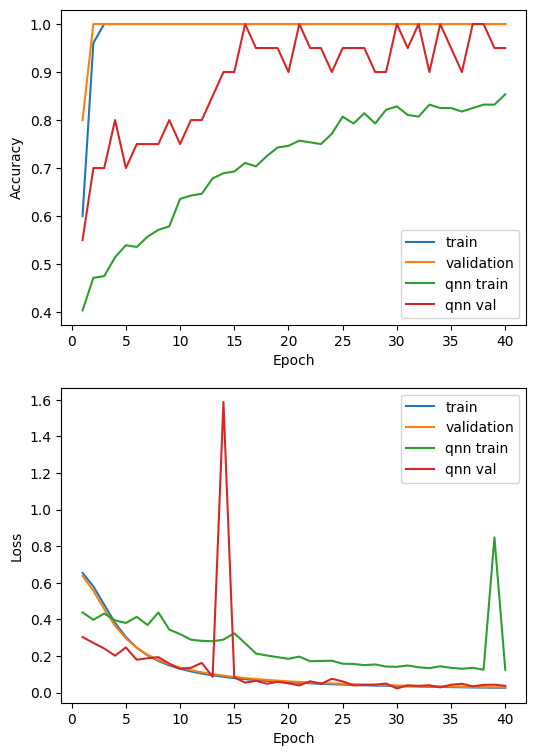

In [32]:
epoch_step = 1
steps = range(1, 41, epoch_step)
# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(steps, train_history.history["accuracy"], label="train")
ax1.plot(steps, train_history.history["val_accuracy"], label="validation")
ax1.plot(range(1, 41), train_acc_history, label='qnn train')
ax1.plot(range(1, 41), val_acc_history, label='qnn val')
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(steps, train_history.history["loss"], label="train")
ax2.plot(steps, train_history.history["val_loss"], label="validation")
ax2.plot(range(1, 41), train_loss_history, label='qnn train')
ax2.plot(range(1, 41), val_loss_history, label='qnn val')
ax2.set_ylabel("Loss")
# ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
# plt.tight_layout()
plt.show()

# intersect 0.25

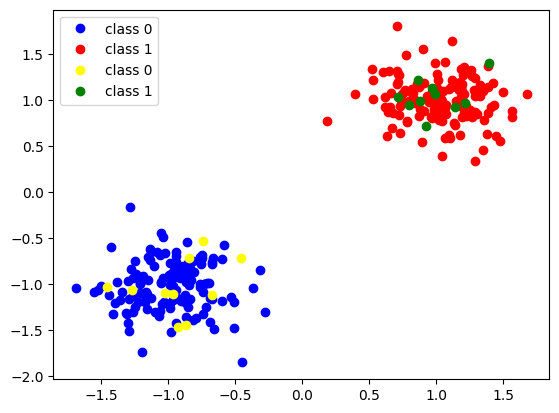

In [24]:
trainX, trainY, ValX, ValY = create_data_set(.250)

visualize_dataset(trainX, trainY, ValX, ValY)

In [25]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

optimizer = qml.optimize.AdamOptimizer(stepsize=0.035)
# optimizer = qml.GradientDescentOptimizer(stepsize=0.025)
steps = 40
var = np.array([0.5]*params_num, requires_grad=True)
for step in range(steps):
    print(f'step {step+1}  |  trainable params: {var}')
    var = optimizer.step(lambda v: cost(v, trainX, trainY), var)

    predictions = np.array([classifier(var, x) for x in ValX], requires_grad=False)
    val_accuracy = accuracy(ValY, np.round(predictions))
    val_loss = square_loss(ValY, predictions)

    predictions = np.array([classifier(var, x) for x in trainX], requires_grad=False)
    train_accuracy = accuracy(trainY, np.round(predictions))
    train_loss = square_loss(trainY, predictions)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

step 1  |  trainable params: [0.5 0.5 0.5 0.5 0.5 0.5]
Iter:     1 | Train Loss: 0.4488356 | Train accuracy: 0.48214285714285715 | Val Loss: 0.4430289 | Val_accuracy: 0.5 
step 2  |  trainable params: [0.535 0.535 0.535 0.535 0.535 0.535]
Iter:     2 | Train Loss: 0.4581620 | Train accuracy: 0.5035714285714286 | Val Loss: 0.4007409 | Val_accuracy: 0.55 
step 3  |  trainable params: [0.5678842  0.56090271 0.56503622 0.56708329 0.55774072 0.56398762]
Iter:     3 | Train Loss: 0.4057675 | Train accuracy: 0.55 | Val Loss: 0.3750274 | Val_accuracy: 0.55 
step 4  |  trainable params: [0.60153001 0.58939193 0.59671962 0.5944644  0.5860478  0.59528156]
Iter:     4 | Train Loss: 0.3768034 | Train accuracy: 0.5607142857142857 | Val Loss: 0.3317925 | Val_accuracy: 0.55 
step 5  |  trainable params: [0.62862657 0.61587089 0.62336981 0.62418068 0.61072546 0.62344124]
Iter:     5 | Train Loss: 0.3925857 | Train accuracy: 0.6214285714285714 | Val Loss: 0.2498021 | Val_accuracy: 0.7 
step 6  |  traina

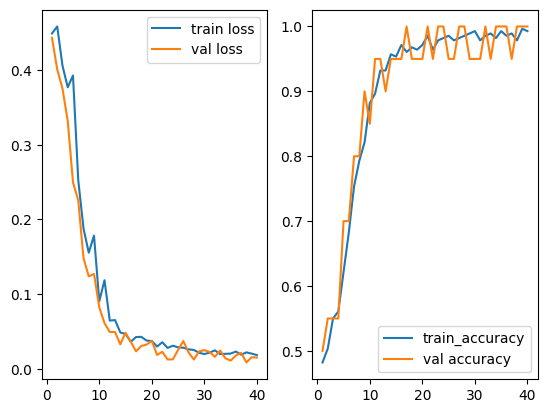

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(range(1, steps+1), train_loss_history, label='train loss')
axs[0].plot(range(1, steps+1), val_loss_history, label='val loss')
# axs[0].
axs[0].legend()

axs[1].plot(range(1, steps+1), train_acc_history, label='train_accuracy')
axs[1].plot(range(1, steps+1), val_acc_history, label='val accuracy')
axs[1].legend()

plt.show()

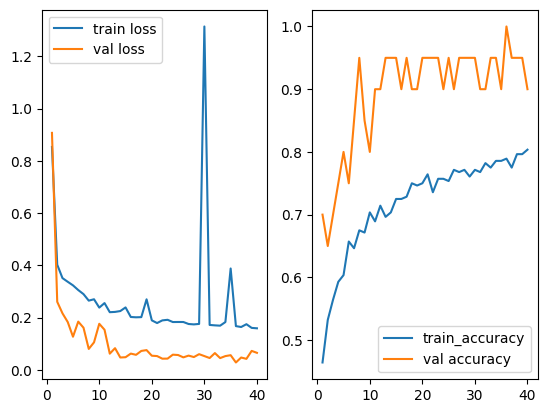

In [27]:
epochs = 40
model = Sequential([Dense(2, activation=tf.nn.softmax, input_shape=[2]), Dense(2, activation=tf.nn.softmax)])
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_history = model.fit(
    trainX,
    trainY,
    validation_data=(ValX, ValY),
    batch_size=2,
    epochs=epochs,
    verbose=2
)

Epoch 1/40
140/140 - 1s - loss: 0.7155 - accuracy: 0.4607 - val_loss: 0.6136 - val_accuracy: 1.0000 - 989ms/epoch - 7ms/step
Epoch 2/40
140/140 - 0s - loss: 0.5373 - accuracy: 1.0000 - val_loss: 0.4623 - val_accuracy: 1.0000 - 195ms/epoch - 1ms/step
Epoch 3/40
140/140 - 0s - loss: 0.4053 - accuracy: 1.0000 - val_loss: 0.3499 - val_accuracy: 1.0000 - 209ms/epoch - 1ms/step
Epoch 4/40
140/140 - 0s - loss: 0.3092 - accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 1.0000 - 222ms/epoch - 2ms/step
Epoch 5/40
140/140 - 0s - loss: 0.2418 - accuracy: 1.0000 - val_loss: 0.2151 - val_accuracy: 1.0000 - 203ms/epoch - 1ms/step
Epoch 6/40
140/140 - 0s - loss: 0.1948 - accuracy: 1.0000 - val_loss: 0.1762 - val_accuracy: 1.0000 - 202ms/epoch - 1ms/step
Epoch 7/40
140/140 - 0s - loss: 0.1612 - accuracy: 1.0000 - val_loss: 0.1479 - val_accuracy: 1.0000 - 202ms/epoch - 1ms/step
Epoch 8/40
140/140 - 0s - loss: 0.1365 - accuracy: 1.0000 - val_loss: 0.1268 - val_accuracy: 1.0000 - 199ms/epoch - 1ms/step


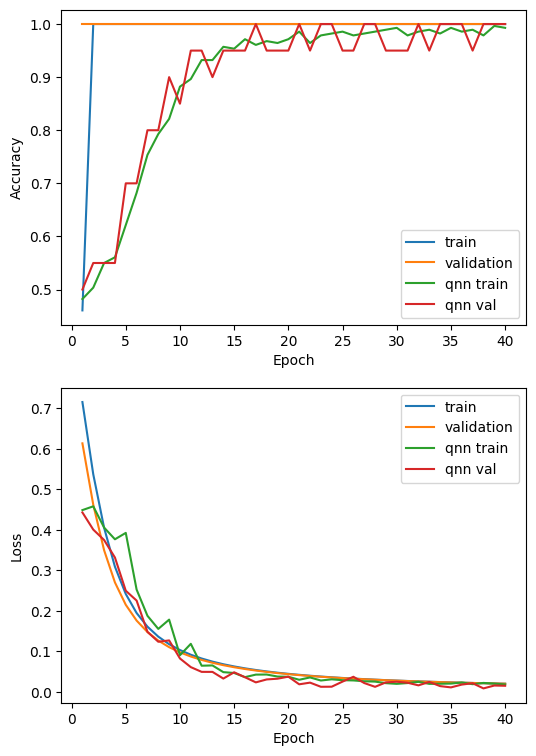

In [28]:
epoch_step = 1
steps = range(1, 41, epoch_step)
# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(steps, train_history.history["accuracy"], label="train")
ax1.plot(steps, train_history.history["val_accuracy"], label="validation")
ax1.plot(range(1, 41), train_acc_history, label='qnn train')
ax1.plot(range(1, 41), val_acc_history, label='qnn val')
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(steps, train_history.history["loss"], label="train")
ax2.plot(steps, train_history.history["val_loss"], label="validation")
ax2.plot(range(1, 41), train_loss_history, label='qnn train')
ax2.plot(range(1, 41), val_loss_history, label='qnn val')
ax2.set_ylabel("Loss")
# ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
# plt.tight_layout()
plt.show()

# intersect 1.0

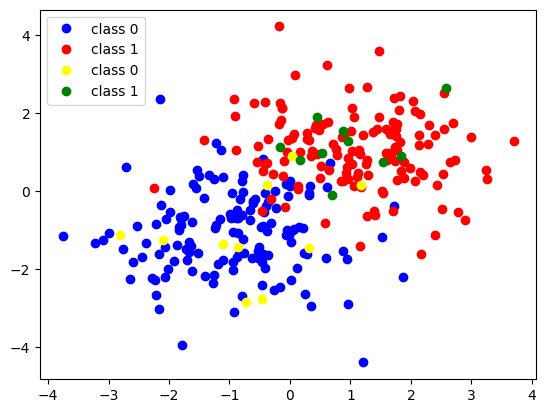

In [29]:
trainX, trainY, ValX, ValY = create_data_set(1.0)

visualize_dataset(trainX, trainY, ValX, ValY)

In [42]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

optimizer = qml.optimize.AdamOptimizer(stepsize=0.01)
# optimizer = qml.GradientDescentOptimizer(stepsize=0.025)
steps = 40
var = np.array([0.7]*params_num, requires_grad=True)
for step in range(steps):
    print(f'step {step+1}  |  trainable params: {var}')
    var = optimizer.step(lambda v: cost(v, trainX, trainY), var)

    predictions = np.array([classifier(var, x) for x in ValX], requires_grad=False)
    val_accuracy = accuracy(ValY, np.round(predictions))
    val_loss = square_loss(ValY, predictions)

    predictions = np.array([classifier(var, x) for x in trainX], requires_grad=False)
    train_accuracy = accuracy(trainY, np.round(predictions))
    train_loss = square_loss(trainY, predictions)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

step 1  |  trainable params: [0.7 0.7 0.7 0.7 0.7 0.7]
Iter:     1 | Train Loss: 0.2608150 | Train accuracy: 0.5892857142857143 | Val Loss: 0.2164758 | Val_accuracy: 0.6 
step 2  |  trainable params: [0.71 0.71 0.71 0.71 0.71 0.71]
Iter:     2 | Train Loss: 0.2524436 | Train accuracy: 0.5857142857142857 | Val Loss: 0.2188219 | Val_accuracy: 0.65 
step 3  |  trainable params: [0.71929916 0.71910405 0.71972219 0.71913636 0.71973226 0.71997241]
Iter:     3 | Train Loss: 0.2571504 | Train accuracy: 0.5964285714285714 | Val Loss: 0.2274825 | Val_accuracy: 0.55 
step 4  |  trainable params: [0.72781111 0.72665716 0.72779025 0.72735741 0.7281701  0.72924133]
Iter:     4 | Train Loss: 0.2365172 | Train accuracy: 0.6178571428571429 | Val Loss: 0.2224071 | Val_accuracy: 0.55 
step 5  |  trainable params: [0.73648796 0.7350528  0.73593141 0.73603111 0.73718703 0.73852985]
Iter:     5 | Train Loss: 0.2463928 | Train accuracy: 0.5857142857142857 | Val Loss: 0.2111764 | Val_accuracy: 0.7 
step 6  | 

In [38]:
epochs = 40
model = Sequential([Dense(2, activation=tf.nn.softmax, input_shape=[2]), Dense(2, activation=tf.nn.softmax)])
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_history = model.fit(
    trainX,
    trainY,
    validation_data=(ValX, ValY),
    batch_size=2,
    epochs=epochs,
    verbose=2
)

Epoch 1/40
140/140 - 1s - loss: 0.6863 - accuracy: 0.5393 - val_loss: 0.6785 - val_accuracy: 0.5500 - 1s/epoch - 8ms/step
Epoch 2/40
140/140 - 0s - loss: 0.6595 - accuracy: 0.7143 - val_loss: 0.6424 - val_accuracy: 0.9000 - 218ms/epoch - 2ms/step
Epoch 3/40
140/140 - 0s - loss: 0.6055 - accuracy: 0.9179 - val_loss: 0.5782 - val_accuracy: 0.9000 - 207ms/epoch - 1ms/step
Epoch 4/40
140/140 - 0s - loss: 0.5287 - accuracy: 0.9143 - val_loss: 0.5062 - val_accuracy: 0.9000 - 253ms/epoch - 2ms/step
Epoch 5/40
140/140 - 0s - loss: 0.4527 - accuracy: 0.9286 - val_loss: 0.4453 - val_accuracy: 0.9000 - 213ms/epoch - 2ms/step
Epoch 6/40
140/140 - 0s - loss: 0.3902 - accuracy: 0.9286 - val_loss: 0.4005 - val_accuracy: 0.9000 - 242ms/epoch - 2ms/step
Epoch 7/40
140/140 - 0s - loss: 0.3428 - accuracy: 0.9286 - val_loss: 0.3698 - val_accuracy: 0.9000 - 198ms/epoch - 1ms/step
Epoch 8/40
140/140 - 0s - loss: 0.3077 - accuracy: 0.9250 - val_loss: 0.3482 - val_accuracy: 0.9000 - 214ms/epoch - 2ms/step
Epo

In [ ]:
epoch_step = 1
steps = range(1, 41, epoch_step)
# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(steps, train_history.history["accuracy"], label="train")
ax1.plot(steps, train_history.history["val_accuracy"], label="validation")
ax1.plot(range(1, 41), train_acc_history, label='qnn train')
ax1.plot(range(1, 41), val_acc_history, label='qnn val')
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(steps, train_history.history["loss"], label="train")
ax2.plot(steps, train_history.history["val_loss"], label="validation")
ax2.plot(range(1, 41), train_loss_history, label='qnn train')
ax2.plot(range(1, 41), val_loss_history, label='qnn val')
ax2.set_ylabel("Loss")
# ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
# plt.tight_layout()
plt.show()

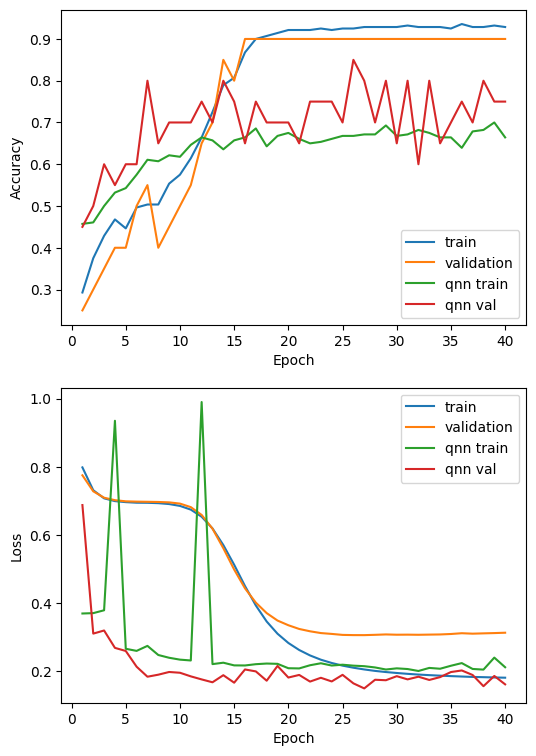